# Malaria Blood Cell Detection

**Importing the libraries**

In [1]:
import numpy as np
import os
import cv2
from PIL import Image
import tensorflow.keras as keras
from tensorflow.keras.layers import Flatten, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Dense

In [2]:
img_dir = "../input/cell-images-for-detecting-malaria/cell_images/cell_images"
uninfected = "../input/cell-images-for-detecting-malaria/cell_images/Uninfected"
parasitized = "../input/cell-images-for-detecting-malaria/cell_images/Parasitized"
classes = os.listdir(img_dir)
print(classes)

['Uninfected', 'Parasitized']


In [3]:
SIZE = 64
BATCH_SIZE = 32
train_ds = keras.preprocessing.image_dataset_from_directory(img_dir,
                                                #label_mode="binary",
                                                seed=42,
                                                validation_split=0.2,
                                                subset="training",
                                                image_size=(SIZE, SIZE),
                                                batch_size=BATCH_SIZE)

val_ds = keras.preprocessing.image_dataset_from_directory(img_dir,
                                                #label_mode="binary",
                                                seed=42,
                                                validation_split=0.2,
                                                subset="validation",
                                                image_size=(SIZE, SIZE),
                                                batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


2022-01-14 19:22:04.595874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 19:22:04.683062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 19:22:04.683804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 19:22:04.686569: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


**Demo picture of Uninfected**

Image shape: (151, 124, 3)


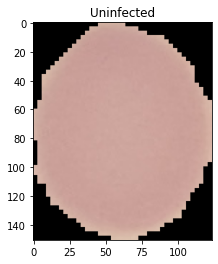

In [4]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class

    random_image = random.sample(os.listdir(target_folder), 1)

    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
  
    print(f"Image shape: {img.shape}")
    return img
uninfected_images = view_random_image(target_dir="../input/cell-images-for-detecting-malaria/cell_images/cell_images/",
                 target_class='Uninfected')

**Demo picture of Parasitized**

Image shape: (133, 136, 3)


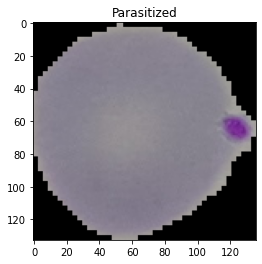

In [5]:
parasitized_images = view_random_image(target_dir="../input/cell-images-for-detecting-malaria/cell_images/cell_images/",
                 target_class='Parasitized')

In [6]:
def plot_loss_curve(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # plot loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.title('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.legend()

# Building CNN model

In [7]:
INPUT_SHAPE = (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)
data_aug = keras.layers.experimental.preprocessing.Rescaling(1./255)(inp)
conv1 = Conv2D(32, kernel_size=3, activation="relu",
              padding="same")(data_aug)
pool1 = MaxPooling2D(2)(conv1)
norm1 = BatchNormalization(axis= -1)(pool1)
drop1 = Dropout(0.2)(norm1)

conv2 = Conv2D(32, kernel_size=3, activation="relu",
              padding="same")(drop1)
pool2 = MaxPooling2D(2)(conv2)
norm2 = BatchNormalization(axis= -1)(pool2)
drop2 = Dropout(0.2)(norm2)

flat = Flatten()(drop2)

hidden1 = Dense(512, activation="relu")(flat)
norm3 = BatchNormalization(axis= -1)(hidden1)
drop3 = Dropout(0.2)(norm3)

hidden2 = Dense(512, activation="relu")(drop3)
norm4 = BatchNormalization(axis= -1)(hidden2)
drop4 = Dropout(0.2)(norm4)

out = Dense(2, activation="sigmoid")(drop4)

model1 = keras.Model(inputs=inp, outputs=out)
model1.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
print(model1.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248  

# Training model

In [8]:
history1 = model1.fit(train_ds,
                   epochs=10,
                   steps_per_epoch=len(train_ds),
                   validation_data=val_ds,
                   validation_steps=len(val_ds))

Epoch 1/10


2022-01-14 19:22:12.817576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-14 19:22:14.727918: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


689/689 [==============================] - 78s 102ms/step - loss: 0.4925 - accuracy: 0.7882 - val_loss: 0.9759 - val_accuracy: 0.7732
Epoch 2/10
689/689 [==============================] - 23s 33ms/step - loss: 0.2492 - accuracy: 0.9089 - val_loss: 0.1944 - val_accuracy: 0.9338
Epoch 3/10
689/689 [==============================] - 23s 33ms/step - loss: 0.2068 - accuracy: 0.9258 - val_loss: 0.1482 - val_accuracy: 0.9492
Epoch 4/10
689/689 [==============================] - 24s 34ms/step - loss: 0.1718 - accuracy: 0.9395 - val_loss: 0.1611 - val_accuracy: 0.9530
Epoch 5/10
689/689 [==============================] - 24s 35ms/step - loss: 0.1515 - accuracy: 0.9474 - val_loss: 0.1805 - val_accuracy: 0.9379
Epoch 6/10
689/689 [==============================] - 24s 34ms/step - loss: 0.1417 - accuracy: 0.9527 - val_loss: 0.1494 - val_accuracy: 0.9494
Epoch 7/10
689/689 [==============================] - 24s 35ms/step - loss: 0.1314 - accuracy: 0.9543 - val_loss: 0.2321 - val_accuracy: 0.9350
Ep

# Plotting loss training & validation curve

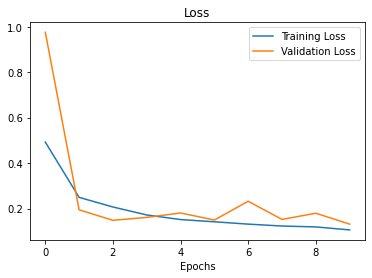

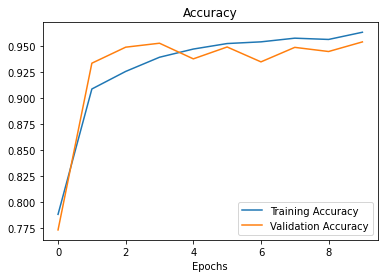

In [9]:
plot_loss_curve(history1)

# Accuracy of model

In [10]:
result = model1.evaluate(val_ds)

173/173 [==============================] - 4s 24ms/step - loss: 0.1314 - accuracy: 0.9543


# Saving the model

In [11]:
model1.save('malaria.h5')

# Using selected image to check the model

In [12]:
test_image = r"../input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png"

The given blood cell is  Parasitic


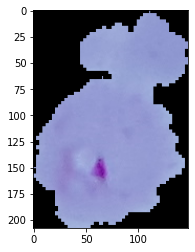

In [13]:
from keras.preprocessing import image
def load(filename):
    img = cv2.imread(filename)
    plt.imshow(img)
    img = image.load_img(test_image, target_size = (SIZE, SIZE))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    index = model1.predict(img)
    index = index.argmax().item()
    if index == 0:
        return "Parasitic"
    elif img == 1:
        return "Non-Parasitic"
    else :
        return
    
image = load(test_image)
print('The given blood cell is ',image)
